In [439]:
"""
In this example, we construct a 3D room. We extrude a 3D room from the floor
with a given height. Then, we place two sources and microphone (-array)
in the room and compute the room impulse response. The simulation is done using the hybrid ISM/RT simulator.
Using this response, we can either process a WAV file and simulate how soundwaves
will propagate in the room, or we can process a unit step signal and save it as WAV file.
Such output file can be later analysed further. We have used Room EQ Wizard (REW)'s
"Import impulse response" functionality to calculate frequency response as well as waterfall
and spectral delay.

I have used this example to model room shape, more complex than shoebox. I have played around with
absorption materials on different walls to find out:
(1) which absorption materials are more/less effective for this room
(2) which walls should be treated to give best effect

As a result, I found out that:
 - empty room response is very bad, there's a long flutter echo (as expected)
 - if I consider placing absorbers on one wall only, it should be front wall (behind speakers)
 - if I add absorption to either side walls or ceiling, it only slightly reduces reverbation time and roughness
   of frequency response curve
 - having absorption on four walls (front, sides, ceiling) dramatically improves both audible effects and frequency
   response/spectral delay
 - additional absorption on back wall would reduct reverbation of the room almost completely. This is something
   i can't have in my room (as back wall is part of Kitchen/Living room), so it was great to be able to at least
   simulate it and hear it
   
In end effect, I have decided to use:
 - rockwool absorbers on the ceiling and side walls
 - a lot of big diaphragmatic bass traps on the front wall or in front corners (i'm considering a pair of corner-mounted
 Primacoustic MaxTraps as well as pair of FullTraps behind speakers), with some additional, thin rockwool absorbers for
 further treatment of remaining places on front wall
 
I'm pretty eager to hear the real results - sadly, for this i need to wait several weeks, to get everything delivered.
I feel great that I could use computer simulation to support my decision. The result is, basically, consistent with
"live-end, dead-end" methodology, which is widely adopted. In my case, there's no back room of the studio - there is
whole kitchen/living room, as it's one open space. Let's see how it behaves :)
"""
from __future__ import print_function

import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.io import wavfile

import pyroomacoustics as pra

In [432]:
### Create the 2D room from the floor polygon - units are meters
pol = np.array([
    [0,      0], 
    [2.98,   0], 
    [2.98,   2.26], 
    [7.2,    2.26], 
    [7.2,    6.05],
    [7.2,    7.31], 
    [5.01,   7.31],
    [5.01,   6.05],
    [2.55,   6.05],
    [2.55,   7.31],
    [0,      7.31],
    [0,      6.05],
    [0,      2.26],
]).T

source_points = [
    [0.82, 0.7, 1.4],
    [2.16, 0.7, 1.4],
]

listener_point = [1.49, 1.55, 1.40]

height = 2.477

output_filename="de-r1_fr_se_ce_2src.wav"

materials = {
    'front': 'rockwool_50mm_80kgm3',
    'sides': 'hard_surface',
    'back': 'hard_surface',
    'floor': 'wood_16mm',
    'ceiling': 'rockwool_50mm_80kgm3'
}

# rockwool_50mm_80kgm3 hard_surface plasterboard wood_16mm ceiling_melamine_foam

# Materials for side walls
mat = sum([
    pra.make_materials(materials['front']),  # Front
    pra.make_materials(materials['sides']),  # Side      
    pra.make_materials("hard_surface"),
    pra.make_materials("plasterboard"),
    pra.make_materials("glass_window"),
    pra.make_materials("hard_surface"),
    pra.make_materials("glass_window"),
    pra.make_materials("glass_window"),
    pra.make_materials("hard_surface"),
    pra.make_materials("hard_surface"),
    pra.make_materials("hard_surface"),
    pra.make_materials("hard_surface"),
    pra.make_materials(materials['sides']),  # Side
], [])

# Create 2D room
room = pra.Room.from_corners(
    pol,
    fs=16000,
    materials=mat,
    max_order=3,
    ray_tracing=True,
    air_absorption=True,
)

# Create the 3D room by extruding the 2D by height
xmat = {
    'floor':   pra.make_materials(materials['floor'])[0],
    'ceiling': pra.make_materials(materials['ceiling'])[0],
}
room.extrude(height, materials=xmat)

# Add source(s) somewhere in the room
fs, audio_anechoic = wavfile.read("german_speech_8000.wav") # Read and process specific audio recording, for rehearsal
#audio_anechoic = sp.signal.unit_impulse(16000) # Use unit impulse function, for analysis with REW or other tools
for srp in source_points:
    room.add_source(srp, signal=audio_anechoic)

# Add a microphone
room.add_microphone(listener_point)

In [425]:
# Compute the RIR using 'hybrid' method
room.set_ray_tracing(receiver_radius=0.5)
chrono = time.time()
room.compute_rir()
print("RIR computation done in", time.time() - chrono, "seconds.")
print("RT60:", room.measure_rt60()[0, 0])
#room.plot_rir()
#plt.show()

RIR computation done in 2655.8643078804016 seconds.
RT60: 9.8876875


In [426]:
# Simulate room response, based on RIR
chrono = time.time()
room.simulate()
print("Room simulation done in", time.time() - chrono, "seconds.")
chrono = time.time()
audio_reverb = room.mic_array.to_wav(output_filename, norm=True, bitdepth=np.int16)
print("Audio processing done in", time.time() - chrono, "seconds, output:", output_filename)

Room simulation done in 0.1711580753326416 seconds.
Audio processing done in 0.005856990814208984 seconds, output:  de-r1_fr_se_ce_2src.wav


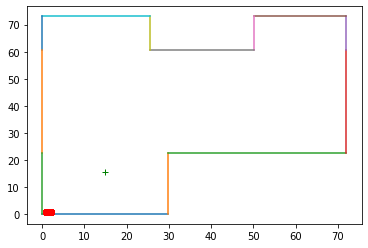

In [428]:
# Visualise room shape and sources/microphones
prev=[0, 0]
for p in pol.T[1:]:
    plt.plot([prev[0],p[0]],[prev[1],p[1]])
    prev=p
plt.plot([prev[0],0],[prev[1],0])

for srp in source_points:
    plt.plot(srp[0], srp[1], "ro")
plt.plot(listener_point[0], listener_point[1], "g+")